In [352]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [353]:
def corr2d(X, K):  
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [354]:
x= torch.ones((6, 8))
x[:, 2:6] = 0
K = torch.tensor([[1.0, -1.0],[1.0, -1.0]])
Y = corr2d(x, K)

Y.shape

torch.Size([5, 7])

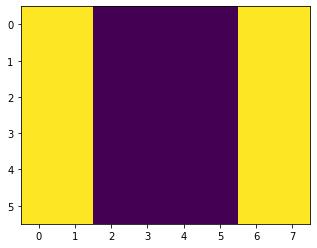

In [355]:
plt.imshow(x)

In [356]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class conv2d(torch.nn.Module):
  def __init__(self):
    super(conv2d, self).__init__()
    self.conv = nn.LazyConv2d(1, kernel_size=(2,2), bias=False)
  def forward(self, x):
    x = self.conv(x)
    
    return x

In [357]:
model = conv2d()
model

conv2d(
  (conv): LazyConv2d(0, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
)

epoch 10, loss 0.805
epoch 20, loss 0.568
epoch 30, loss 0.402
epoch 40, loss 0.284
epoch 50, loss 0.201
epoch 60, loss 0.142
epoch 70, loss 0.101
epoch 80, loss 0.071
epoch 90, loss 0.050
epoch 100, loss 0.036


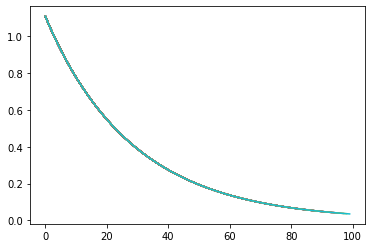

In [358]:
lr = 3e-2  # Learning rate
losses = []
loss_function = torch.nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0)

for i in range(100):
    x = x.reshape((1, 1, 6, 8))
    Y = Y.reshape((1, 1, 5, 7))
    model.zero_grad()

    Y_hat = model(x)
    l = loss_function(Y_hat , Y)
    l = l.sum()
    l.backward()
    # Update the kernel

    optim.step()

    loss = l.item()
    losses.append(loss)
    plt.plot(losses)
    if (i + 1) % 10 == 0:
        print(f'epoch {i + 1}, loss {l.mean():.3f}')

In [359]:
model.conv.weight.data.reshape((2, 2))

tensor([[ 0.6620, -0.9821],
        [ 0.9906, -0.6705]])

In [360]:

model.zero_grad()
out = model(torch.tensor(x.reshape((1, 1, 6, 8)).float()))
out.retain_grad()
loss = loss_function(out, torch.tensor(Y)).mean()
loss.retain_grad()
loss.backward()
model.conv.weight.data.reshape((2, 2))


tensor([[ 0.6620, -0.9821],
        [ 0.9906, -0.6705]])

In [361]:
def corr2d(X, K):  
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [362]:
def corr2d_full(K,d_loss):
    pad = d_loss.shape[0] - 1
    K = np.pad(K.T, pad, mode='constant')
    h,w = d_loss.shape
    Y = np.zeros((4,4))
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (K[i:i + h , j:j +w ] * d_loss).sum()
    return Y

In [363]:
#numpy forward pass 
w = model.conv.weight.detach().numpy().reshape(2,2)
def forward(x):
    return corr2d(x, w)

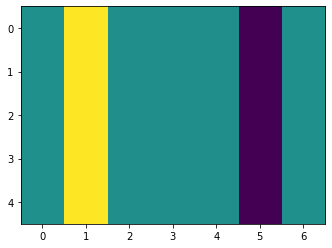

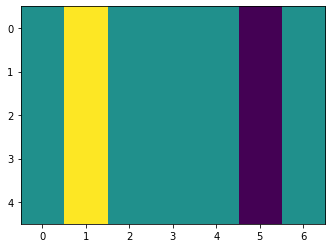

In [364]:
x= torch.ones((6, 8))
x[:, 2:6] = 0
K = torch.tensor([[1.0, -1.0],[1.0, -1.0]])
Y = corr2d(x, K)
plt.figure()
plt.imshow(forward(x))
plt.figure()
plt.imshow(Y)

In [365]:
def forward_backward(x,Y,w):
    
    #forward
    c2d = corr2d(x,w)
    xloss = ((c2d - Y) ** 2).mean()
    
    #backward
    d_z = 2*(c2d - Y)
    d_w = corr2d(x, d_z)
    d_x = corr2d_full( w, d_z)
    return d_x, d_w , xloss

In [366]:
d_x, d_w, xloss = forward_backward(x,Y,w)
d_w

array([[-3.47377777,  3.47501397],
       [-3.47377777,  3.47501397]])

epoch 10, loss 0.020
epoch 20, loss 0.000
epoch 30, loss 0.000
epoch 40, loss 0.000
epoch 50, loss 0.000
epoch 60, loss 0.000
epoch 70, loss 0.000
epoch 80, loss 0.000
epoch 90, loss 0.000
epoch 100, loss 0.000


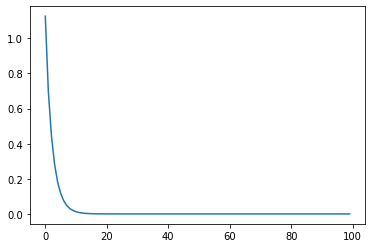

In [367]:
lr = 0.01  # Learning rate
losses = []
# numpy training
def layer_init(m, h):
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)

  return ret.astype(np.float32)
w =   layer_init(2,2)
for i in range(100):
    x = x.reshape(( 6, 8))
    Y = Y.reshape(( 5, 7))
    d_x, d_w, xloss = forward_backward(x,Y, w)

    w = w - lr * d_w
    loss = xloss
    losses.append(loss)
    if (i + 1) % 10 == 0:
        print(f'epoch {i + 1}, loss {loss:.3f}')
plt.plot(losses)

In [369]:
print(w)

[[ 0.70614055 -1.26870543]
 [ 1.29385945 -0.73129457]]
